# Observe top and bottom merchants from ranking system

In [58]:
from pyspark.sql.functions import *
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
predictions = pd.read_parquet('../data/curated/lr_transaction_predictions.parquet')
merchants_df = pd.read_parquet('../data/curated/merchants.parquet')

In [7]:
merchants_df = merchants_df[['merchant_abn', 'name','segment']]
total_ranking = predictions.groupby('merchant_abn').sum().sort_values(by = 'weighted_dollar_value', ascending = False)
total_ranking = total_ranking[['weighted_dollar_value']]
segments_ranking = merchants_df.join(total_ranking, on='merchant_abn', how='right')
total_ranking = segments_ranking[['merchant_abn','name','weighted_dollar_value']]

misc_df = segments_ranking[segments_ranking['segment'] == 'Miscellaneous']
misc_df = misc_df.sort_values(by = 'weighted_dollar_value', ascending = False)

home_df = segments_ranking[segments_ranking['segment'] == 'Home']
home_df = home_df.sort_values(by = 'weighted_dollar_value', ascending = False)

acc_df = segments_ranking[segments_ranking['segment'] == 'Accessories']
acc_df = acc_df.sort_values(by = 'weighted_dollar_value', ascending = False)

art_df = segments_ranking[segments_ranking['segment'] == 'Art']
art_df = art_df.sort_values(by = 'weighted_dollar_value', ascending = False)

tech_df = segments_ranking[segments_ranking['segment'] == 'Media & Technology']
tech_df = tech_df.sort_values(by = 'weighted_dollar_value', ascending = False)

In [56]:
# Observing best merchants

topTen = total_ranking.sort_values(by = 'weighted_dollar_value', ascending = False).head(10)
topTen

,merchant_abn,name,weighted_dollar_value
3154,79827781481,Amet Risus Inc.,84001.727162
1034,32361057556,Orci In Consequat Corporation,83155.451151
1766,48534649627,Dignissim Maecenas Foundation,82641.999103
3443,86578477987,Leo In Consulting,80189.674176
1329,38700038932,Etiam Bibendum Industries,80006.719445
3881,96680767841,Ornare Limited,77117.781440
519,21439773999,Mauris Non Institute,76308.881769
1637,45629217853,Lacus Consulting,76122.079393
2386,63123845164,Odio Phasellus Institute,75511.357080
2446,64403598239,Lobortis Ultrices Company,74505.204105


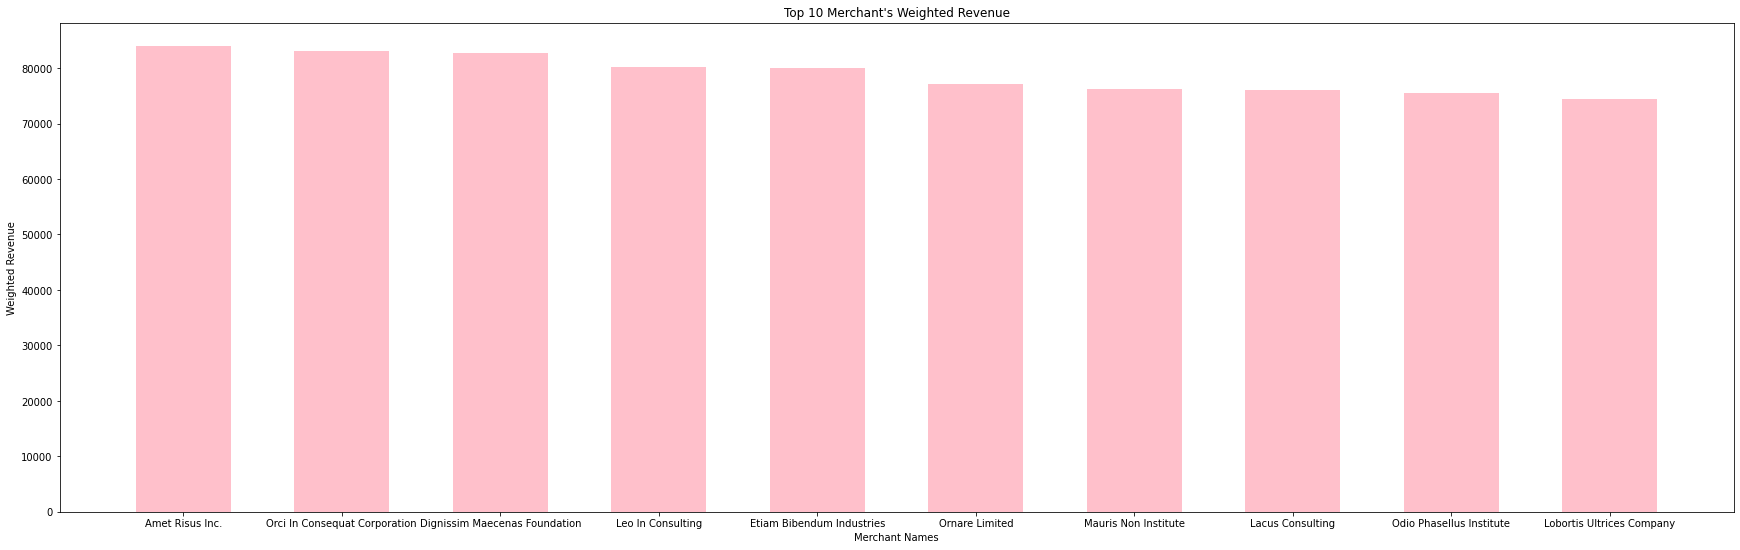

In [86]:
# Create histogram for top 10 merchants

histData = topTen[['name', 'weighted_dollar_value']]
x = histData['name']
y = histData['weighted_dollar_value']

fig = plt.figure(figsize=(30, 9))
plt.bar(x, y, width=0.6, color='pink', edgecolor = None)
plt.xlabel("Merchant Names")
plt.ylabel("Weighted Revenue")
plt.title("Top 10 Merchant's Weighted Revenue")
plt.show()

In [11]:
# Observing worst merchants

total_ranking.sort_values(by = 'weighted_dollar_value', ascending = True).head(20)

,merchant_abn,name,weighted_dollar_value
658,24212300522,Consectetuer Industries,4.184918
2067,55555661470,Nullam Scelerisque LLC,4.184918
419,19340071232,Magna Sed Associates,4.900691
2072,55622580330,Lacus LLP,6.048617
2008,54277261175,In Magna PC,8.860830
687,25019506172,Proin Vel Inc.,9.215218
2145,57079678065,Hendrerit Donec Limited,9.356863
2438,64196096120,Turpis Incorporated,9.878175
3029,76866488151,Euismod Urna Company,10.052972
1677,46391946761,Libero Nec Ligula LLP,11.058243


# Observe relevant information for selected merchants

In [12]:
from pyspark.sql import SparkSession


spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.driver.memory", '4g')
    .config("spark.executor.memory", '8g')
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.parquet.enableVectorizedReader","false")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .getOrCreate()
)

22/10/10 00:51:35 WARN Utils: Your hostname, dash_surface resolves to a loopback address: 127.0.1.1; using 172.24.204.1 instead (on interface eth0)
22/10/10 00:51:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 00:51:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [13]:
transactions_sdf = spark.read.parquet('../data/curated/cleaned_transactions.parquet/')

In [14]:
merchant_info = spark.read.parquet('../data/curated/merchants.parquet')

In [24]:
predictions = spark.read.parquet('../data/curated/lr_transaction_predictions.parquet')

In [27]:
predictions = predictions.groupBy(F.col('merchant_abn')).agg({
    'weighted_dollar_value': 'sum'
})

### Info on best merchant

In [34]:
# Number 1 ranked merchant

topMerchant = transactions_sdf.where(F.col('merchant_abn') == 79827781481)

In [9]:
# Find take rate

merchant_info.where(F.col('merchant_abn') == 79827781481)

merchant_abn,name,category,revenue_level,take_rate,category_indexed,segment
79827781481,Amet Risus Inc.,"[furniture, home ...",a,0.0682,11,Home


In [35]:
total = topMerchant.count()

In [36]:
print(f"Top merchant total count: {total}")

Top merchant total count: 4245


In [30]:
topMerchant

merchant_abn,sum(weighted_dollar_value)
79827781481,84001.72716168387


### Info on 2nd best merchant

In [38]:
# 2nd best merchant

secondMerchant = transactions_sdf.where(F.col('merchant_abn') == 32361057556)

In [39]:
merchant_info.where(F.col('merchant_abn') == 32361057556)

merchant_abn,name,category,revenue_level,take_rate,category_indexed,segment
32361057556,Orci In Consequat...,"[gift, card, nove...",a,0.0661,12,Miscellaneous


In [40]:
stotal = secondMerchant.count()

In [41]:
print(f"2nd merchant total count: {stotal}")

2nd merchant total count: 75702


In [42]:
secondRev = predictions.where(F.col('merchant_abn') == 32361057556)

In [44]:
secondRev

merchant_abn,sum(weighted_dollar_value)
32361057556,83155.45115140988


### Info on 20th merchant

In [45]:
# 20th best merchant

twentyMerchant = transactions_sdf.where(F.col('merchant_abn') == 76767266140)

In [46]:
merchant_info.where(F.col('merchant_abn') == 76767266140)

merchant_abn,name,category,revenue_level,take_rate,category_indexed,segment
76767266140,Phasellus At Limited,"[furniture, home ...",b,0.04650000000000001,11,Home


In [47]:
ttotal = twentyMerchant.count()

In [48]:
print(f"20th merchant total count: {ttotal}")

20th merchant total count: 38431


In [26]:
# Find total revnue for merchant

twentyMerchant.groupBy(F.col('merchant_abn')).agg({
    'dollar_value': 'sum'
})

merchant_abn,sum(dollar_value)
76767266140,8243403.799999999


In [49]:
twentyRev = predictions.where(F.col('merchant_abn') == 76767266140)

In [50]:
twentyRev

merchant_abn,sum(weighted_dollar_value)
76767266140,57833.37485545214


### Info on worst ranked merchant

In [51]:
# Worst ranked merchant

badMerchant = transactions_sdf.where(F.col('merchant_abn') == 24212300522)

In [52]:
merchant_info.where(F.col('merchant_abn') == 24212300522)

merchant_abn,name,category,revenue_level,take_rate,category_indexed,segment
24212300522,Consectetuer Indu...,"[jewelry, watch, ...",b,0.0404,15,Accessories


In [53]:
btotal = badMerchant.count()

In [54]:
print(f"Worst merchant total count: {btotal}")

Worst merchant total count: 0


From these results, it is evident that our ranking system is in fact working properly - the highest ranked merchant brings the BNPL service the highest revenue, with all merchants following it returning reduced amounts of revenue. Our lowest ranked merchant currently has no transactions attached to it.